In [1]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [2]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path (change if needed)
DATA_DIR = "/kaggle/input/dataset-of-plant-parasitic-nematodes/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset using ImageFolder
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 80:20 (Train:Test)
test_ratio = 0.2
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 813, Test: 203
Train: 732, Validation: 81, Test: 203


In [3]:
# ===============================================================
# 🔰 Step 3 — Model: GoogLeNet (Updated for Torchvision ≥ 0.13)
# ===============================================================
from torchvision.models import googlenet, GoogLeNet_Weights

# ✅ Use modern weights API
weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)  # aux_logits=True by default

# ⚙️ Disable auxiliary classifier during training if not needed
model.aux_logits = False

# ✅ Replace final fully connected layer
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ✅ Move model to device
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 72.1MB/s]


In [4]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [5]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")



Epoch 1/50


Train Loss: 2.0857, Acc: 0.3156 | Val Loss: 1.8020, Acc: 0.4074

Epoch 2/50


Train Loss: 1.4481, Acc: 0.6243 | Val Loss: 1.4373, Acc: 0.5802

Epoch 3/50


Train Loss: 1.0132, Acc: 0.8019 | Val Loss: 1.1569, Acc: 0.6543

Epoch 4/50


Train Loss: 0.7093, Acc: 0.8962 | Val Loss: 0.9489, Acc: 0.8025

Epoch 5/50


Train Loss: 0.4551, Acc: 0.9467 | Val Loss: 0.7874, Acc: 0.7901

Epoch 6/50


Train Loss: 0.2863, Acc: 0.9781 | Val Loss: 0.7205, Acc: 0.8025

Epoch 7/50


Train Loss: 0.2081, Acc: 0.9809 | Val Loss: 0.6416, Acc: 0.8148

Epoch 8/50


Train Loss: 0.1337, Acc: 0.9877 | Val Loss: 0.5866, Acc: 0.8148

Epoch 9/50


Train Loss: 0.1028, Acc: 0.9877 | Val Loss: 0.5985, Acc: 0.8272

Epoch 10/50


Train Loss: 0.0791, Acc: 0.9891 | Val Loss: 0.5553, Acc: 0.8272

Epoch 11/50


Train Loss: 0.0724, Acc: 0.9904 | Val Loss: 0.5297, Acc: 0.8642

Epoch 12/50


Train Loss: 0.0636, Acc: 0.9904 | Val Loss: 0.5836, Acc: 0.8395

Epoch 13/50


Train Loss: 0.0481, Acc: 0.9932 | Val Loss: 0.5188, Acc: 0.8395

Epoch 14/50


Train Loss: 0.0424, Acc: 0.9959 | Val Loss: 0.5864, Acc: 0.8025

Epoch 15/50


Train Loss: 0.0364, Acc: 1.0000 | Val Loss: 0.5486, Acc: 0.8272

Epoch 16/50


Train Loss: 0.0290, Acc: 1.0000 | Val Loss: 0.5241, Acc: 0.8272

Epoch 17/50


Train Loss: 0.0272, Acc: 1.0000 | Val Loss: 0.5216, Acc: 0.8642

Epoch 18/50


Train Loss: 0.0207, Acc: 1.0000 | Val Loss: 0.5580, Acc: 0.8395

Epoch 19/50


Train Loss: 0.0210, Acc: 1.0000 | Val Loss: 0.5625, Acc: 0.8148

Epoch 20/50


Train Loss: 0.0205, Acc: 1.0000 | Val Loss: 0.5303, Acc: 0.8395

Epoch 21/50


Train Loss: 0.0137, Acc: 1.0000 | Val Loss: 0.5287, Acc: 0.8519

Epoch 22/50


Train Loss: 0.0142, Acc: 1.0000 | Val Loss: 0.5476, Acc: 0.8519

Epoch 23/50


Train Loss: 0.0146, Acc: 1.0000 | Val Loss: 0.5395, Acc: 0.8148

Epoch 24/50


Train Loss: 0.0125, Acc: 1.0000 | Val Loss: 0.4932, Acc: 0.8642

Epoch 25/50


Train Loss: 0.0125, Acc: 1.0000 | Val Loss: 0.5343, Acc: 0.8395

Epoch 26/50


Train Loss: 0.0095, Acc: 1.0000 | Val Loss: 0.5175, Acc: 0.8519

Epoch 27/50


Train Loss: 0.0079, Acc: 1.0000 | Val Loss: 0.5092, Acc: 0.8395

Epoch 28/50


Train Loss: 0.0084, Acc: 1.0000 | Val Loss: 0.5077, Acc: 0.8642

Epoch 29/50


Train Loss: 0.0069, Acc: 1.0000 | Val Loss: 0.5585, Acc: 0.8642

Epoch 30/50


Train Loss: 0.0064, Acc: 1.0000 | Val Loss: 0.5186, Acc: 0.8519

Epoch 31/50


Train Loss: 0.0078, Acc: 1.0000 | Val Loss: 0.5228, Acc: 0.8395

Epoch 32/50


Train Loss: 0.0066, Acc: 1.0000 | Val Loss: 0.5491, Acc: 0.8519

Epoch 33/50


Train Loss: 0.0059, Acc: 1.0000 | Val Loss: 0.5450, Acc: 0.8765

Epoch 34/50


Train Loss: 0.0060, Acc: 1.0000 | Val Loss: 0.5229, Acc: 0.8765

Epoch 35/50


Train Loss: 0.0049, Acc: 1.0000 | Val Loss: 0.5337, Acc: 0.8519

Epoch 36/50


Train Loss: 0.0054, Acc: 1.0000 | Val Loss: 0.5269, Acc: 0.8642

Epoch 37/50


Train Loss: 0.0040, Acc: 1.0000 | Val Loss: 0.5262, Acc: 0.8642

Epoch 38/50


Train Loss: 0.0039, Acc: 1.0000 | Val Loss: 0.5075, Acc: 0.8642

Epoch 39/50


Train Loss: 0.0041, Acc: 1.0000 | Val Loss: 0.5381, Acc: 0.8765

Epoch 40/50


Train Loss: 0.0037, Acc: 1.0000 | Val Loss: 0.5035, Acc: 0.8889

Epoch 41/50


Train Loss: 0.0040, Acc: 1.0000 | Val Loss: 0.5152, Acc: 0.8889

Epoch 42/50


Train Loss: 0.0031, Acc: 1.0000 | Val Loss: 0.5063, Acc: 0.8765

Epoch 43/50


Train Loss: 0.0037, Acc: 1.0000 | Val Loss: 0.4762, Acc: 0.8889

Epoch 44/50


Train Loss: 0.0026, Acc: 1.0000 | Val Loss: 0.5020, Acc: 0.8765

Epoch 45/50


Train Loss: 0.0037, Acc: 1.0000 | Val Loss: 0.4950, Acc: 0.8642

Epoch 46/50


Train Loss: 0.0032, Acc: 1.0000 | Val Loss: 0.4647, Acc: 0.8889

Epoch 47/50


Train Loss: 0.0032, Acc: 1.0000 | Val Loss: 0.4784, Acc: 0.8889

Epoch 48/50


Train Loss: 0.0031, Acc: 1.0000 | Val Loss: 0.5008, Acc: 0.8642

Epoch 49/50


Train Loss: 0.0026, Acc: 1.0000 | Val Loss: 0.4827, Acc: 0.8642

Epoch 50/50


Train Loss: 0.0023, Acc: 1.0000 | Val Loss: 0.5073, Acc: 0.8765

✅ Total training time: 856.24 sec


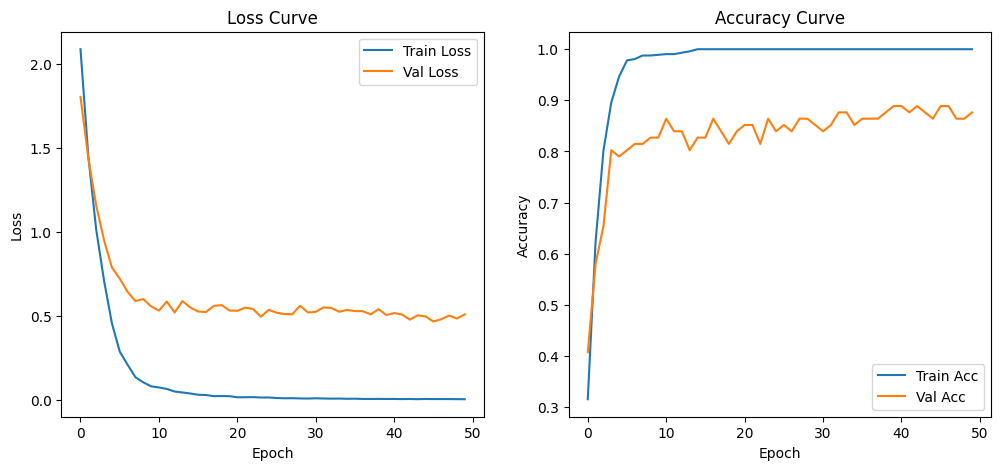

In [6]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [7]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_googlenet_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 81.77%
✅ Test time: 5.81 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     0.9583    1.0000    0.9787        23
Genus Helicotylenchus     0.9286    0.9286    0.9286        28
Genus Hemicycliophora     0.0000    0.0000    0.0000         1
 Genus Hirschmaniella     0.8519    0.8214    0.8364        28
    Genus Hoplolaimus     0.9091    0.7895    0.8451        38
    Genus Meloidogyne     0.7838    0.8286    0.8056        35
   Genus Pratylenchus     0.6000    0.6667    0.6316        18
     Genus Radopholus     0.7778    0.7000    0.7368        10
    Genus Trichodorus     0.8571    0.7500    0.8000         8
      Genus Xiphinema     0.5556    0.7143    0.6250        14

             accuracy                         0.8177       203
            macro avg     0.7222    0.7199    0.7188       203
         weighted avg     0.8231    0.8177    0.8183       203



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


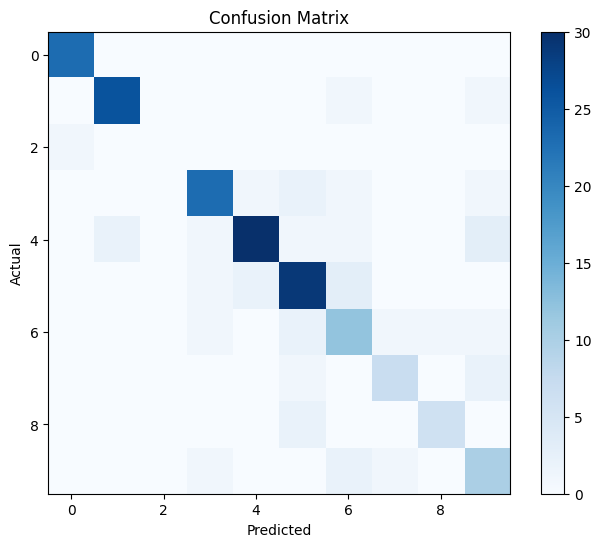


Per-class Accuracy:
Genus Criconemoides: 100.00%
Genus Helicotylenchus: 92.86%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 82.14%
Genus Hoplolaimus: 78.95%
Genus Meloidogyne: 82.86%
Genus Pratylenchus: 66.67%
Genus Radopholus: 70.00%
Genus Trichodorus: 75.00%
Genus Xiphinema: 71.43%


In [8]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


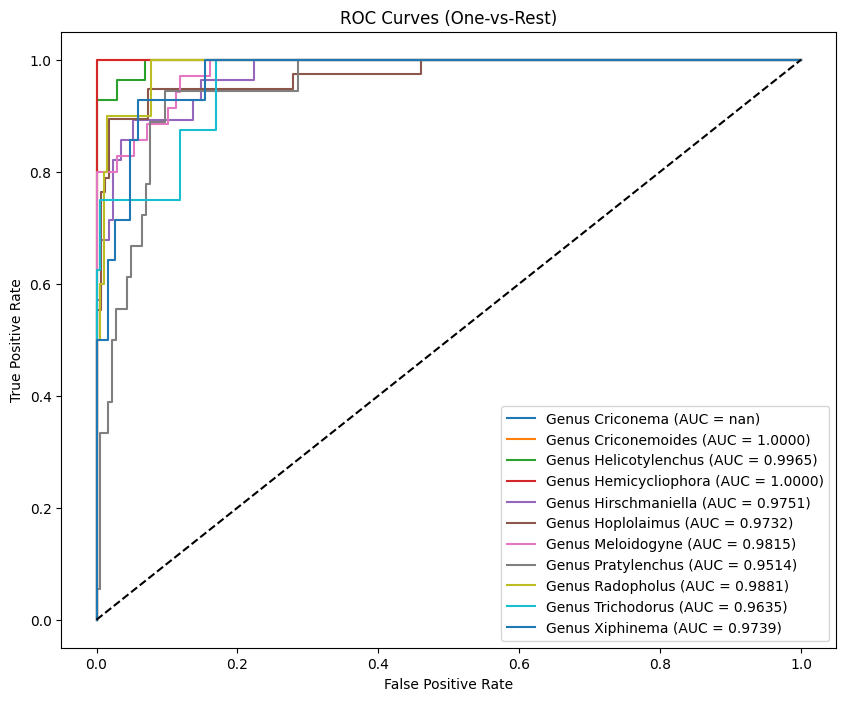

In [9]:
# ===============================================================
# 🔰 Step 9 — ROC-AUC per class
# ===============================================================
import numpy as np
from sklearn.metrics import roc_curve, auc

# Ensure numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # ✅ Convert to binary (1 vs rest)
    binary_labels = (all_labels == i).astype(int)
    
    # ✅ Calculate ROC curve for this class
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [10]:
# ===============================================================
# 🔰 Step 10 — Full Metrics Evaluation
# ===============================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall    = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1        = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("✅ Full Model Metrics on Test Set:")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")


✅ Full Model Metrics on Test Set:
Accuracy : 81.77%
Precision: 82.31%
Recall   : 81.77%
F1-Score : 81.83%
